In [29]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
print(utils_path)
sys.path.append(str(utils_path))

from pathlib import Path
from rasterio.crs import CRS
from crop_utils import (crop_image_by_coordinates, 
                        crop_image_by_geojson_shp, 
                        reproject_geotiff)
from edit_path_utils import (edit_paths)

import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_utils import (preprocess_data,
                           superpixel_segmentation,
                            tv_denoise, 
                            preprocess_for_merge)
from rio_utils import (reproject_arr_to_match_profile)

/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/Alpha_Code/wildfire_new/uavsar-main/python


In [2]:
shp_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca")
# shps = sorted(list(shp_dir.glob('./*.shp')))
shps = sorted([shp for shp in shp_dir.glob('*.shp') if not shp.name.startswith('._')])
shps

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_mask.shp')]

In [3]:
##shps = '../data/bobcat/uavsar_perimeter/bobcat_perimeter_bilinear_inc_south.geojson'
shps = '/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'
shps

'/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'

In [4]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [5]:
def inc_filter(img):
    img_deg = np.rad2deg(img)
    mask = (img_deg < 25) | (img_deg > 65)
    img_deg[mask] = 999
    return img_deg

In [6]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

In [7]:
def weighted_inc_merge(img_0, img_1, inc_0, inc_1):
    
    valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 25) & (inc_0 <= 65)
    valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 25) & (inc_1 <= 65)
    invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 25) | (inc_0 > 65)
    invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 25) | (inc_1 > 65)

    w0 = inc_0 / (inc_0 + inc_1)
    w1 = inc_1 / (inc_0 + inc_1)
    img_merged = np.empty_like(img_0)
    img_merged[:] = np.nan

    # combine valid pixels
    img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
    img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

    # combine cases where one pixel is valid and the other is not
    img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
    img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]

    return img_merged


In [8]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data")

tifs = sorted([tif for tif in data_dir.glob('*alpha1_perimeter_crop.tif') if not tif.name.startswith('._')])
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26526_18076_002_181011_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26528_18001_009_180205_alpha1_perimeter_crop.tif')]

In [9]:
tifs[0], tifs[2], tifs[1], tifs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26526_18076_002_181011_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26528_18001_009_180205_alpha1_perimeter_crop.tif'))

In [10]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data")

incs = sorted(list(data_dir.rglob('./*inc_box_crop_perimeter*.tif')))
incs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26526_18076_002_181011_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26528_18001_009_180205_L090_CX_01_inc_box_crop_perimeter_crop.tif')]

In [11]:
incs[0], incs[2], incs[1], incs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26526_18076_002_181011_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26528_18001_009_180205_L090_CX_01_inc_box_crop_perimeter_crop.tif'))

In [30]:
bands, profiles = zip(*map(open_one, tifs))

bands = list(bands)
for i in range(len(bands)):
    bands[i] = preprocess_for_merge(bands[i]) # mask out the missing data after RTC. Scale the values to ensure consistency

pre_south_w_to_e = bands[0]
pre_north_w_to_e = bands[1]
pre_south_e_to_w = bands[2]
pre_north_e_to_w = bands[3]
profile_pre_south_w_to_e = profiles[0]
profile_pre_north_w_to_e = profiles[1]
profile_pre_south_e_to_w = profiles[2]
profile_pre_north_e_to_w = profiles[3]



In [13]:
inc_bands, inc_profiles = zip(*map(open_one, incs))

inc_bands = list(inc_bands)
for i in range(len(inc_bands)):
    inc_bands[i] = inc_filter(inc_bands[i]) # convert angle from radian to degree. Filter out the bad angles

pre_inc_south_w_to_e = inc_bands[0]
pre_inc_north_w_to_e = inc_bands[1]
pre_inc_south_e_to_w = inc_bands[2]
pre_inc_north_e_to_w = inc_bands[3]
profile_inc_pre_south_w_to_e = inc_profiles[0]
profile_inc_pre_north_w_to_e = inc_profiles[1]
profile_inc_pre_south_e_to_w = inc_profiles[2]
profile_inc_pre_north_e_to_w = inc_profiles[3]

In [14]:
resampling = 'bilinear'

In [15]:
pre_south_e_to_w , _ = reproject_arr_to_match_profile(pre_south_e_to_w , profile_pre_south_e_to_w , profile_pre_south_w_to_e, resampling=resampling)
pre_south_e_to_w  = pre_south_e_to_w[0]
pre_north_w_to_e, _ = reproject_arr_to_match_profile(pre_north_w_to_e, profile_pre_north_w_to_e, profile_pre_south_w_to_e, resampling=resampling)
pre_north_w_to_e = pre_north_w_to_e[0]
pre_north_e_to_w, _ = reproject_arr_to_match_profile(pre_north_e_to_w, profile_pre_north_e_to_w, profile_pre_south_w_to_e, resampling=resampling)
pre_north_e_to_w = pre_north_e_to_w[0]

pre_inc_south_w_to_e, _ = reproject_arr_to_match_profile(pre_inc_south_w_to_e, profile_inc_pre_south_w_to_e, profile_pre_south_w_to_e , resampling=resampling)
pre_inc_south_w_to_e = pre_inc_south_w_to_e[0]
pre_inc_south_e_to_w, _ = reproject_arr_to_match_profile(pre_inc_south_e_to_w, profile_inc_pre_south_e_to_w, profile_pre_south_w_to_e, resampling=resampling)
pre_inc_south_e_to_w = pre_inc_south_e_to_w[0]

pre_inc_north_w_to_e, _ = reproject_arr_to_match_profile(pre_inc_north_w_to_e, profile_inc_pre_south_e_to_w, profile_pre_south_w_to_e , resampling=resampling)
pre_inc_north_w_to_e = pre_inc_north_w_to_e[0]
pre_inc_north_e_to_w, _ = reproject_arr_to_match_profile(pre_inc_north_e_to_w, profile_inc_pre_north_e_to_w, profile_pre_south_w_to_e , resampling=resampling)
pre_inc_north_e_to_w = pre_inc_north_e_to_w[0]

In [16]:

alpha_south = weighted_inc_merge(pre_south_w_to_e, pre_south_e_to_w, pre_inc_south_w_to_e, pre_inc_south_e_to_w)
alpha_north = weighted_inc_merge(pre_north_w_to_e, pre_north_e_to_w , pre_inc_north_w_to_e, pre_inc_north_e_to_w)

In [17]:
output_path_0 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/bobcat_alpha_0.tif"
output_path_1 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/bobcat_alpha_1.tif"

In [18]:
with rasterio.open(output_path_0, "w", **profile_pre_south_w_to_e) as dest:
    dest.write(alpha_south, 1)

with rasterio.open(output_path_1, "w", **profile_pre_south_w_to_e) as dest:
    dest.write(alpha_north, 1)


In [19]:
print(alpha_south.shape)

(4921, 6093)


In [20]:
print(alpha_north.shape)

(4921, 6093)


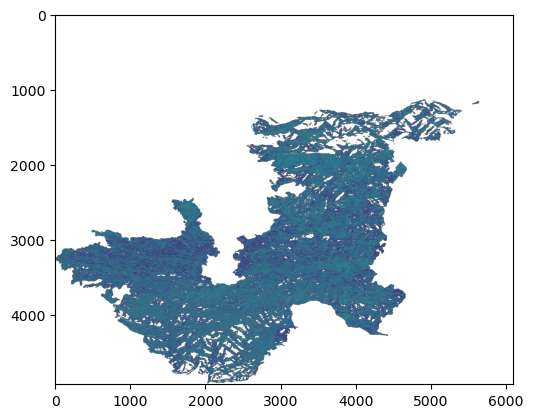

In [21]:
plt.imshow(alpha_south)

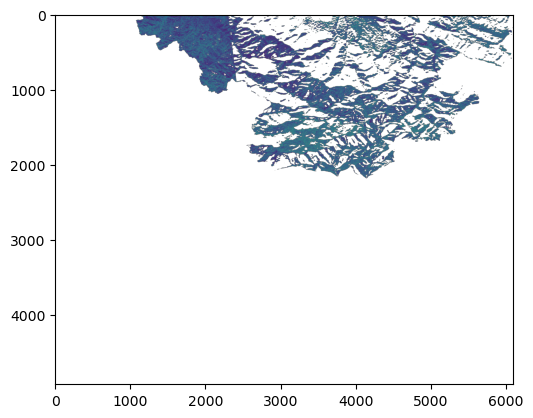

In [22]:
plt.imshow(alpha_north)

In [25]:
pre_alpha_merged = np.nanmax(np.stack([alpha_south, alpha_north]), axis=0)


/tmp/ipykernel_15483/3321054171.py:1: RuntimeWarning: All-NaN slice encountered
  pre_alpha_merged = np.nanmax(np.stack([alpha_south, alpha_north]), axis=0)


In [34]:
np.sum(pre_alpha_merged)
nan_pre_alpha_merged = np.isnan(pre_alpha_merged)
np.sum(nan_pre_alpha_merged)

np.int64(19795282)

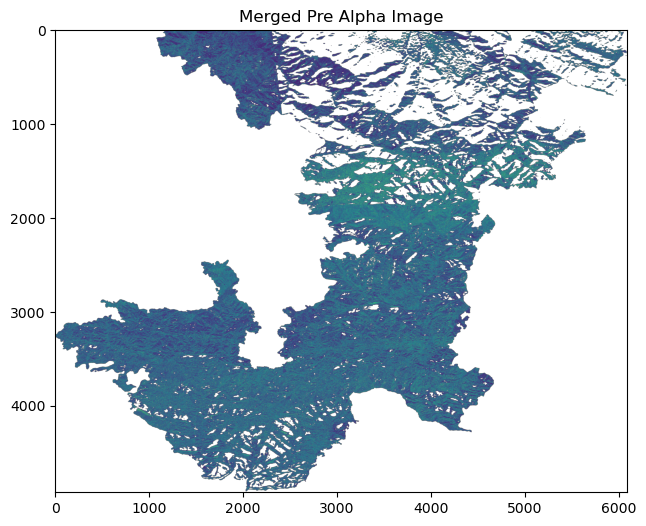

In [26]:
plt.figure(figsize=(10, 6))
plt.title("Merged Pre Alpha Image")
plt.imshow((pre_alpha_merged))
plt.show()


In [27]:


# ---- Save merged alpha to GeoTIFF ----
save_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha_image_test.tif"

# Use one of the inputs to copy geospatial metadata
with rasterio.open(output_path_0) as src:
    profile = src.profile

# Update profile for the merged image
profile.update({
    "height": pre_alpha_merged.shape[0],
    "width": pre_alpha_merged.shape[1],
    "count": 1,
    "dtype": pre_alpha_merged.dtype,
    "compress": "lzw"
})

# Save merged Alpha raster
with rasterio.open(save_path, "w", **profile) as dst:
    dst.write(pre_alpha_merged, 1)


In [28]:
import rasterio
import numpy as np

def print_tif_values(tif_path):
    """
    Print the numerical values and unique values in a TIF file.

    Parameters:
    tif_path (str): Path to the TIF file
    """
    try:
        # Open the TIF file
        with rasterio.open(tif_path) as src:
            # Print basic metadata
            print(f"TIF File: {tif_path}")
            print(f"Width: {src.width}, Height: {src.height}")
            print(f"Number of bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")

            # Read all bands
            for band_idx in range(1, src.count + 1):
                band_data = src.read(band_idx)

                print(f"\nBand {band_idx} data:")

                # If the array is too large, print a sample
                if band_data.size > 100:
                    print("Array is large, showing statistics and sample:")
                    print(f"Min: {np.nanmin(band_data)}, Max: {np.nanmax(band_data)}, Mean: {np.nanmean(band_data):.4f}, Median: {np.nanmedian(band_data):.4f}")
                    print("Sample of data (top-left corner):")
                    print(band_data[:5, :5])  # Show a 5x5 sample from the top left
                else:
                    # If the array is small enough, print all values
                    print(band_data)

                # Extract valid (non-NaN) values and round
                valid = band_data[~np.isnan(band_data)]
                if valid.size > 0:
                    unique_vals = np.unique(np.round(valid, 2))
                    print("Unique values (non-NaN, rounded to 2 decimals):")
                    print(unique_vals[:50])  # Show first 50 for brevity
                else:
                    print("No valid (non-NaN) values found in this band.")

    except Exception as e:
        print(f"Error reading TIF file: {e}")


# Call your function
tif_file_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/bobcat_alpha_0.tif"
tif_file_path_south_e_w = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_alpha1_perimeter_crop.tif"
tif_file_path_north_e_w = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_alpha1_perimeter_crop.tif"
tif_file_path_south_w_e = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26526_18076_002_181011_alpha1_perimeter_crop.tif"
tif_file_path_north_w_e = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_26528_18001_009_180205_alpha1_perimeter_crop.tif"
tif_file_path_north_inc = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_L090_CX_01_inc_box_crop_perimeter_crop.tif"
tif_file_path_pre_merged = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha_image_test.tif"
print_tif_values(tif_file_path_south_e_w)
print_tif_values(tif_file_path_north_e_w)
print_tif_values(tif_file_path_south_w_e)
print_tif_values(tif_file_path_north_w_e)
print_tif_values(tif_file_path)
print_tif_values(tif_file_path_north_inc)
print_tif_values(tif_file_path_pre_merged)


TIF File: /shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08525_18076_003_181011_alpha1_perimeter_crop.tif
Width: 6093, Height: 4921
Number of bands: 1
Data type: float64

Band 1 data:
Array is large, showing statistics and sample:
Min: 0.0, Max: 89.93375177329655, Mean: 10.2372, Median: 0.0000
Sample of data (top-left corner):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Unique values (non-NaN, rounded to 2 decimals):
[0.   0.32 0.42 0.5  0.57 0.6  0.68 0.82 0.84 0.85 0.86 0.88 0.89 0.9
 0.92 0.99 1.   1.01 1.02 1.04 1.05 1.07 1.09 1.13 1.15 1.16 1.18 1.19
 1.21 1.22 1.23 1.24 1.25 1.26 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35
 1.36 1.37 1.38 1.39 1.4  1.41 1.43 1.44]
TIF File: /shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/SanAnd_08527_18001_010_180205_alpha1_perimeter_crop.tif
Width: 6093, Height: 5329
Number of bands: 1
Data type: float64

Band 1 data:
Array is large, 

In [ ]:
# # === Save Prefire alpha1 ===
# pre_alpha1_out_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha1_image_test.npy"
# np.save(pre_alpha1_out_path, pre_alpha_merged)